# compare duplicate runs 

In [34]:
import sys,os,io,shutil,subprocess
import glob
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
import matplotlib as mpl
from Bio import SeqIO
from Bio import AlignIO
import seaborn as sns
sys.path.append('pathogenie')
from snipgenie import tools, aligners, app, trees, plotting
import toytree, toyplot
import toyplot.pdf
import toyplot.png
path = '/storage/btbgenie/all_ireland_results'

In [ ]:
reload(app)
reload(aligners)
args = {'threads':20, 'outdir': '/storage/btbgenie/dup_results', 'labelsep':'_',
        'input':['/storage/btbgenie/mbovis_ireland/duplicates/'],
         'species': 'Mbovis-AF212297',
         'overwrite':True,
         'custom_filters': True,
         'buildtree':True}
W = app.WorkFlow(**args)
st = W.setup()
W.run()

In [35]:
meta = pd.read_csv('/storage/btbgenie/mbovis_ireland/all_ireland_samples.csv')

In [36]:
dups1=meta[meta.duplicated('aliquot',keep='last')].dropna()
dups2=meta[meta.duplicated('aliquot',keep='first')].dropna()
print (len(dups1),len(dups2))
#print (dups2)

17 17


## combine samples into one table

In [37]:
summ1 = pd.read_csv('/storage/btbgenie/dup_results/summary.csv')
summ2 = pd.read_csv('/storage/btbgenie/monaghan/monaghan_results/summary.csv')
summ2 = summ2[summ2['sample'].isin(dups1['sample'])]
print (len(summ1),len(summ2))
df = pd.concat([summ1,summ2])
df['pair'] = df['sample'].apply(lambda x: x[-4:])
df=df[df.pair!='4235']
df = df.sort_values('pair')

16 17


In [141]:
app.write_samples(df,'duplicate_test')

'duplicate_test/samples.txt'

In [ ]:
depths=[]
for i,r in df.iterrows():
    print (r.bam_file)
    c=tools.get_mean_depth(r.bam_file)
    depths.append(c)

In [169]:
df['depth']=depths
df.to_csv('duplicates.csv',index=False)

## call variants on paired duplicates

In [57]:
reload(app)
gff_file='Mbovis_AF212297.gb.gff'
app.run_bamfiles(df.bam_file, app.mbovis_genome, outdir='duplicate_test', threads=20, gff_file=gff_file,
                 #custom_filters=True, mask=app.mbovis_mask,                 
                 overwrite=False)

duplicate_test/raw.bcf already exists
calling variants..
bcftools call --ploidy 1 -m -v -o duplicate_test/calls.vcf duplicate_test/raw.bcf
duplicate_test/samples.txt
bcftools reheader --samples duplicate_test/samples.txt -o /tmp/calls.vcf duplicate_test/calls.vcf
bcftools filter -i "QUAL>=40 && FORMAT/DP>=30 && DP4>=4" -o duplicate_test/filtered.vcf.gz -O z duplicate_test/calls.vcf
splitting snps and indels..
bcftools view -v snps -o duplicate_test/snps.vcf.gz -O z duplicate_test/filtered.vcf.gz
bcftools view -v indels -o duplicate_test/indels.vcf.gz -O z duplicate_test/filtered.vcf.gz
consequence calling..
bcftools csq -f /home/farrell/.config/snipgenie/genome/Mbovis_AF212297.fa -g Mbovis_AF212297.gb.gff duplicate_test/snps.vcf.gz -Ot -o duplicate_test/csq.tsv
bcftools csq -f /home/farrell/.config/snipgenie/genome/Mbovis_AF212297.fa -g Mbovis_AF212297.gb.gff duplicate_test/indels.vcf.gz -Ot -o duplicate_test/csq_indels.tsv
took 17.0 seconds
found 443 sites
23 sites with at least one m

## draw tree

In [356]:
tre = toytree.tree('duplicate_test/tree.newick')
tre=tre.drop_tips(['ref','2014','TB19-002014'])
tre=tre.root('3762')
mapping = dict(zip(df['sample'],df.pair))
colormap = trees.colors_from_labels(df,'sample','pair')
tip_colors = [colormap[mapping[i]] if i in mapping else 'Black' for i in tre.get_tip_labels()]
node_sizes=[0 if i else 8 for i in tre.get_node_values(None, 1, 0)]
node_colors = [colormap[mapping[n]] if n in mapping else 'black' for n in tre.get_node_values('name', True, True)]

canvas,t,r=tre.draw(layout='r',width=1000,height=600,scalebar=True,tip_labels_colors=tip_colors)#tip_labels=False,
                    #node_colors=node_colors,node_sizes=node_sizes);
toyplot.pdf.render(canvas,'duplicate_test/tree_nofilters.pdf')


## read snps

In [58]:
sdist = pd.read_csv('duplicate_test/snpdist.csv',index_col=0)
#sdist.iloc[:10,:10]

In [59]:
dists=[]
for i,g in df.groupby('pair'):
    s1,s2 = list(g['sample'])
    dists.append((s1+'v'+s2,sdist.loc[s1,s2]))
dists=pd.DataFrame(dists,columns=['pair','snps'])
dists2=dists

In [60]:
x=dists1.merge(dists2,on='pair')[1:]
x.columns=['pair','filter','no filter']
x

,pair,filter,no filter
1,3260vTB19-003260,1,4
2,3261vTB19-003261,1,2
3,TB19-003263v3263,0,5
4,TB19-003377v3377,1,2
5,TB19-003437v3437,0,0
6,TB19-003738v3738,2,2
7,TB19-003747v3747,2,2
8,3762vTB19-003762,3,4
9,3825vTB19-003825,1,1
10,4238vTB19-004238,0,0


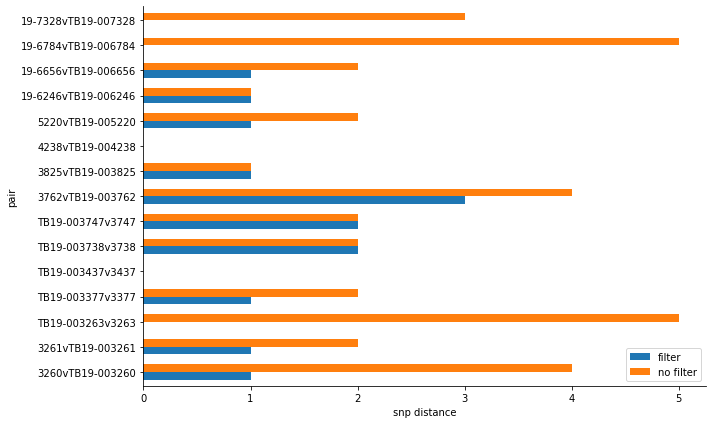

In [61]:
#sns.set_context('talk')
x.plot(x='pair',kind='barh',width=.6,figsize=(10,6))
plt.xlabel('snp distance')
sns.despine()
plt.tight_layout()
plt.savefig('snp_duplicates_dists.jpg',dpi=120)

In [62]:
csqmat = pd.read_csv('duplicate_test/csq.matrix')

In [63]:
dupsnps=[]
for i,g in df.groupby('pair'):
    c = list(g['sample'])   
    s= csqmat[c]
    s = s[s[c[0]]!=s[c[1]]]
    if len(s)==0:
        continue
    found = csqmat.loc[s.index]
    found['samples'] = 'v'.join(c)
    dupsnps.append(found)
    print (found[list(csqmat.columns[:4])+c])
    
dupsnps=pd.concat(dupsnps)

       start            gene         aa    snp_type  TB19-002014  2014
33    333420       PE_PGRS3a       338G  synonymous            1     0
89    928976       PE_PGRS14       753A  synonymous            0     1
194  2246064  BQ2027_MB2038c  112A>112G    missense            1     0
287  3499469   BQ2027_MB3194  190A>190G    missense            1     0
       start       gene           aa    snp_type  3260  TB19-003260
140  1619153  PE_PGRS26         423G  synonymous     1            0
144  1637867  PE_PGRS28         506G  synonymous     1            0
145  1637870  PE_PGRS28         505G  synonymous     1            0
185  2158436      PPE34        1640V  synonymous     0            1
187  2158441      PPE34  1639P>1639A    missense     0            1
188  2158443      PPE34  1638S>1638N    missense     0            1
       start       gene         aa    snp_type  3261  TB19-003261
186  2158439      PPE34      1639P  synonymous     0            1
271  3229680       ppsE  320H>320R   

In [64]:
cols=list(csqmat.columns[:4])+['samples']
dupsnps[cols].sort_values('start')

,start,gene,aa,snp_type,samples
30,252261,pckA,95D>95G,missense,TB19-003738v3738
33,333420,PE_PGRS3a,338G,synonymous,TB19-002014v2014
33,333420,PE_PGRS3a,338G,synonymous,TB19-003437v3437
33,333420,PE_PGRS3a,338G,synonymous,TB19-003738v3738
33,333420,PE_PGRS3a,338G,synonymous,TB19-003377v3377
...,...,...,...,...,...
325,4036120,PE_PGRS61,178G>178R,missense,3261vTB19-003261
325,4036120,PE_PGRS61,178G>178R,missense,TB19-003437v3437
325,4036120,PE_PGRS61,178G>178R,missense,TB19-003747v3747
325,4036120,PE_PGRS61,178G>178R,missense,TB19-003377v3377
